In [1]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import pyrender
import cv2
import glob
import json
import time
import trimesh
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)
from scipy.spatial.transform import Rotation as R
from bpc.inference.utils.camera_utils import load_camera_params
from bpc.inference.process_pose import PoseEstimator, PoseEstimatorParams
from bpc.utils.data_utils import Capture, render_mask
import bpc.utils.data_utils as du
import importlib

Loading camera parameters from: ./datasets/ipd_val/val/000001/scene_camera_cam3.json
[array([[    0.90145,     -0.3749,    -0.21642,       -80.4],
       [    0.32129,      0.9145,    -0.24589,      6.3719],
       [     0.2901,     0.15212,     0.94483,      1710.6],
       [          0,           0,           0,           1]]), array([[   0.012638,    -0.97674,     0.21407,     -95.885],
       [    0.95467,   -0.051885,     -0.2931,       200.7],
       [    0.29739,     0.20807,     0.93181,      1722.1],
       [          0,           0,           0,           1]]), array([[    0.97129,     0.19596,     -0.1349,      66.257],
       [   -0.18554,     0.97886,    0.086008,      290.39],
       [    0.14891,   -0.058508,     0.98712,      1690.5],
       [          0,           0,           0,           1]])]
(2160, 3840, 3)

0: 736x1280 5 object_14s, 133.5ms
Speed: 14.9ms preprocess, 133.5ms inference, 140.7ms postprocess per image at shape (1, 3, 736, 1280)
(2160, 3840, 3)

0: 736

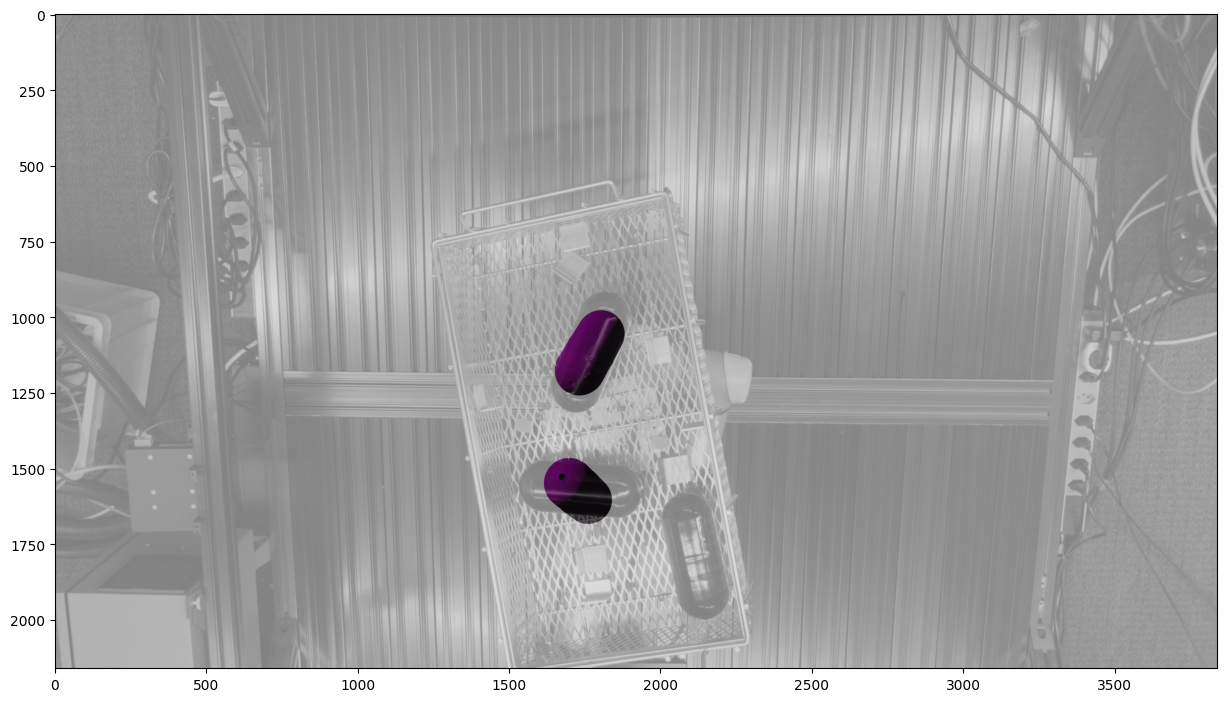

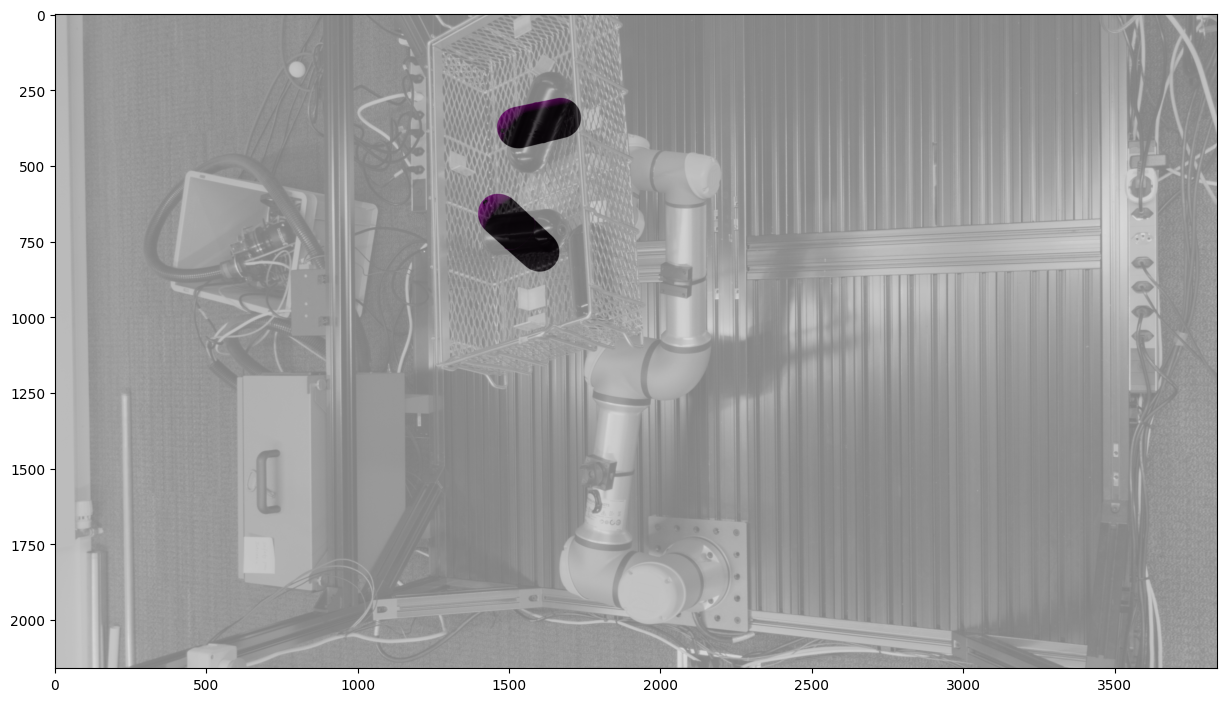

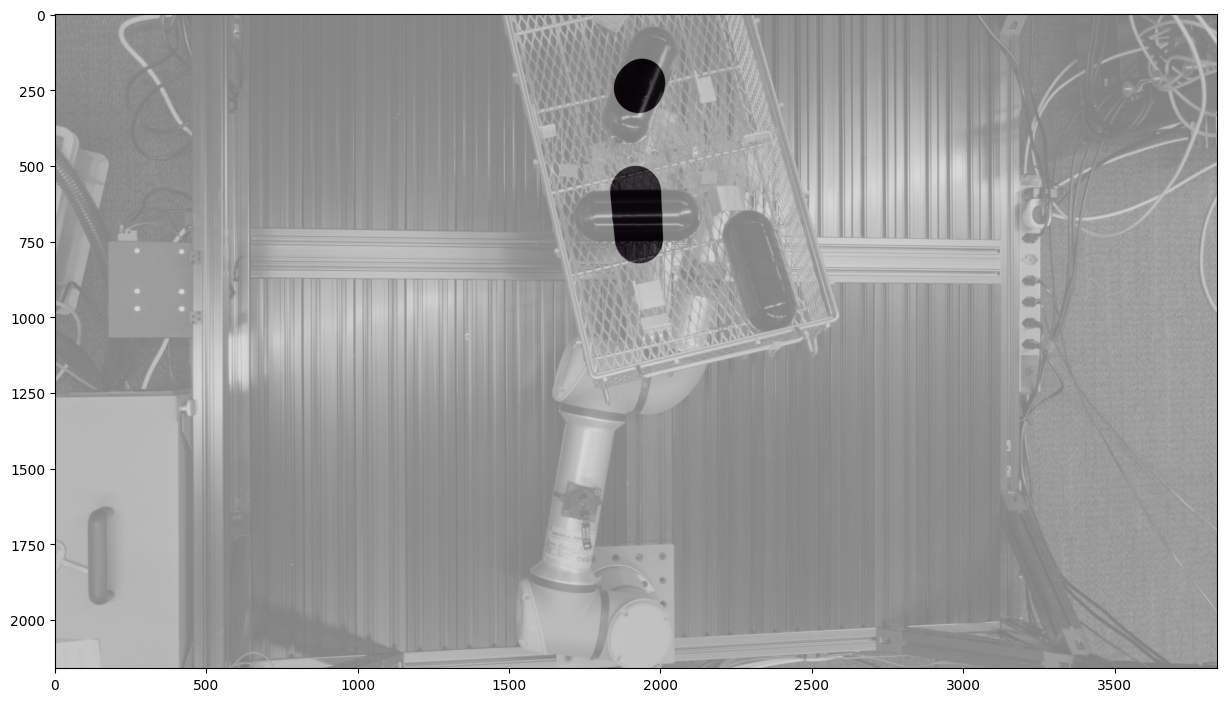

In [2]:
# scene_dir = "./datasets/ipd_bop_data_jan25_1/train_pbr/000000/"
# models_dir = './datasets/ipd_bop_data_jan25_1/models_eval/'
scene_dir = "./datasets/ipd_val/val/000001/"
models_dir = './datasets/ipd_models/models/'
cam_ids = ["cam1", "cam2", "cam3"]
image_id = 3
obj_id = 14
obj_id_path = str(1000000+obj_id)[1:]
ply_file = os.path.join(models_dir, f"obj_{obj_id_path}.ply")
obj = trimesh.load(ply_file)
yolo_model_path = f'models/detection/obj_{obj_id}/yolo11-detection-obj_{obj_id}.pt'
pose_model_path = f'models/rot_models/rot_{obj_id}.pth'

pose_params = PoseEstimatorParams(yolo_model_path=yolo_model_path,
                                  pose_model_path=pose_model_path, 
                                  yolo_conf_thresh=0.01)
pose_estimator = PoseEstimator(pose_params)
t = time.time()
capture = Capture.from_dir(scene_dir, cam_ids, image_id, obj_id)
detections = pose_estimator._detect(capture)
pose_predictions = pose_estimator._match(capture, detections)
pose_estimator._estimate_rotation(pose_predictions)
print(time.time() - t)

for idx in range(len(capture.Ks)):
    plt.figure(figsize=(15, 15))
    plt.imshow(capture.images[idx])
    a, b = render_mask(obj, capture.Ks[idx], (capture.RTs[idx]), capture.images[0].shape[:2][::-1], [x.pose for x in pose_predictions])
    plt.imshow(a, alpha=0.5)
    plt.show()
